In [2]:
%matplotlib inline
from pathlib import Path

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.unet import UNet
from src.evaluate import predict
from src.iou_score import IoU_score
from src.dice_score import dice_coeff
from src.data.datasets import AirbusRawDataset

In [3]:
scores = pd.read_csv('results/evaluation_full.csv', sep=';', index_col=0)
scores.describe()

part           iou          dice
count  2151.0  2.151000e+03  2.151000e+03
mean      0.0  6.334594e-01  7.288283e-01
std       0.0  2.808831e-01  2.764929e-01
min       0.0  5.652017e-12  5.652017e-12
25%       0.0  4.689149e-01  6.384506e-01
50%       0.0  7.402912e-01  8.507671e-01
75%       0.0  8.549034e-01  9.217767e-01
max       0.0  9.665813e-01  9.830067e-01

In [4]:
worst_performing = scores[scores['iou'] < scores['iou'].quantile(0.25)]
worst_performing.head()

ImageId  part           iou          dice
0   000e6378b.jpg     0  8.583691e-02  1.581028e-01
2   00371aa92.jpg     0  4.575163e-01  6.278027e-01
4   004f97cfb.jpg     0  5.764079e-04  1.152152e-03
7   008bc8983.jpg     0  3.300330e-09  3.300330e-09
11  00f89a059.jpg     0  4.285714e-01  6.000000e-01

In [5]:
best_performing = scores[scores['iou'] > scores['iou'].quantile(0.75)]
best_performing.head()

ImageId  part       iou      dice
14  015b2962a.jpg     0  0.875099  0.933389
18  01bb07c7d.jpg     0  0.927257  0.962256
29  02c025c7d.jpg     0  0.915407  0.955836
30  02e39612d.jpg     0  0.926736  0.961975
33  037642165.jpg     0  0.947570  0.973079

In [6]:
# Load model
checkpoint_path = Path('checkpoints/checkpoint_epoch5.pth')
state_dict = torch.load(str(checkpoint_path), map_location='cpu')
del state_dict['learning_rate']

model = UNet(n_channels=3, n_classes=1)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
imgs_dir = Path('data/processed/test/')
test_set = AirbusRawDataset(
    'data/processed/test_ship_segmentations.csv',
    imgs_dir,
)
len(test_set)

2151

In [8]:
def mask_image(img: torch.Tensor, mask: torch.Tensor):
    img = img.permute(1, 2, 0) * 255
    mask = mask.squeeze()
    img[mask] = 0.5 * img[mask] + 0.5 * torch.tensor([255, 0, 0])
    return img.type(torch.uint8)

def create_plots(image_ixs):
    from tqdm import tqdm

    num_samples = len(image_ixs)

    plt.figure(figsize=(14, 8))
    for i, index in tqdm(enumerate(image_ixs), total=num_samples, desc='Predicting output'):
        img, mask = test_set[index]

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(mask_image(img, mask))
        plt.title(test_set.seg_by_img.index[index])
        plt.axis("off")

        mask_pred = predict(model, img)
        mask_pred = mask_pred.squeeze(dim=0)

        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(mask_image(img, mask_pred))
        plt.axis("off")
        
        iou = IoU_score(mask, mask_pred)
        dice = dice_coeff(mask, mask_pred)
        plt.title(f'IoU: {iou*100:.2f}%, Dice: {dice*100:.2f}%')
    plt.tight_layout()

Predicting output: 100%|██████████| 4/4 [00:20<00:00,  5.19s/it]


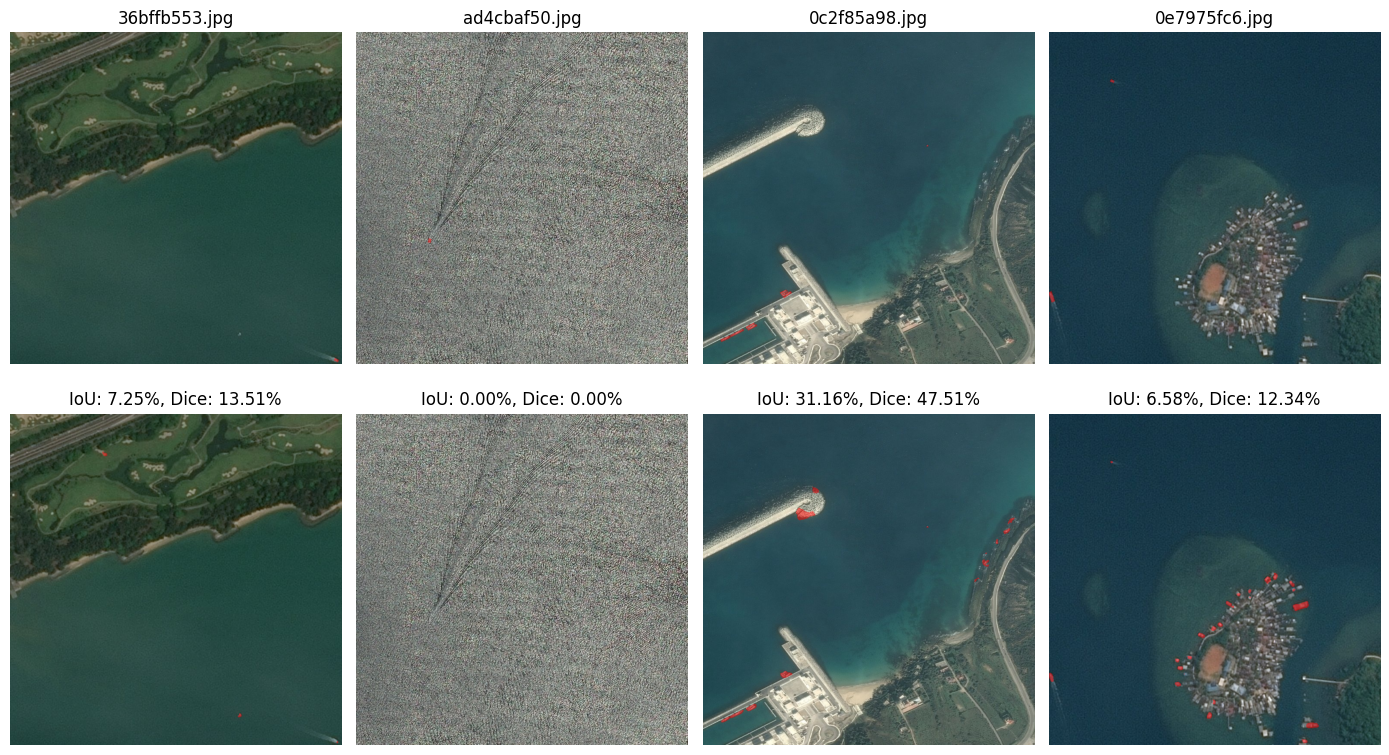

In [12]:
# See some of the worst performing images
num_samples = 4
ixs = np.random.choice(worst_performing.index.values, size=num_samples, replace=False)
create_plots(ixs)

Predicting output: 100%|██████████| 4/4 [00:22<00:00,  5.51s/it]


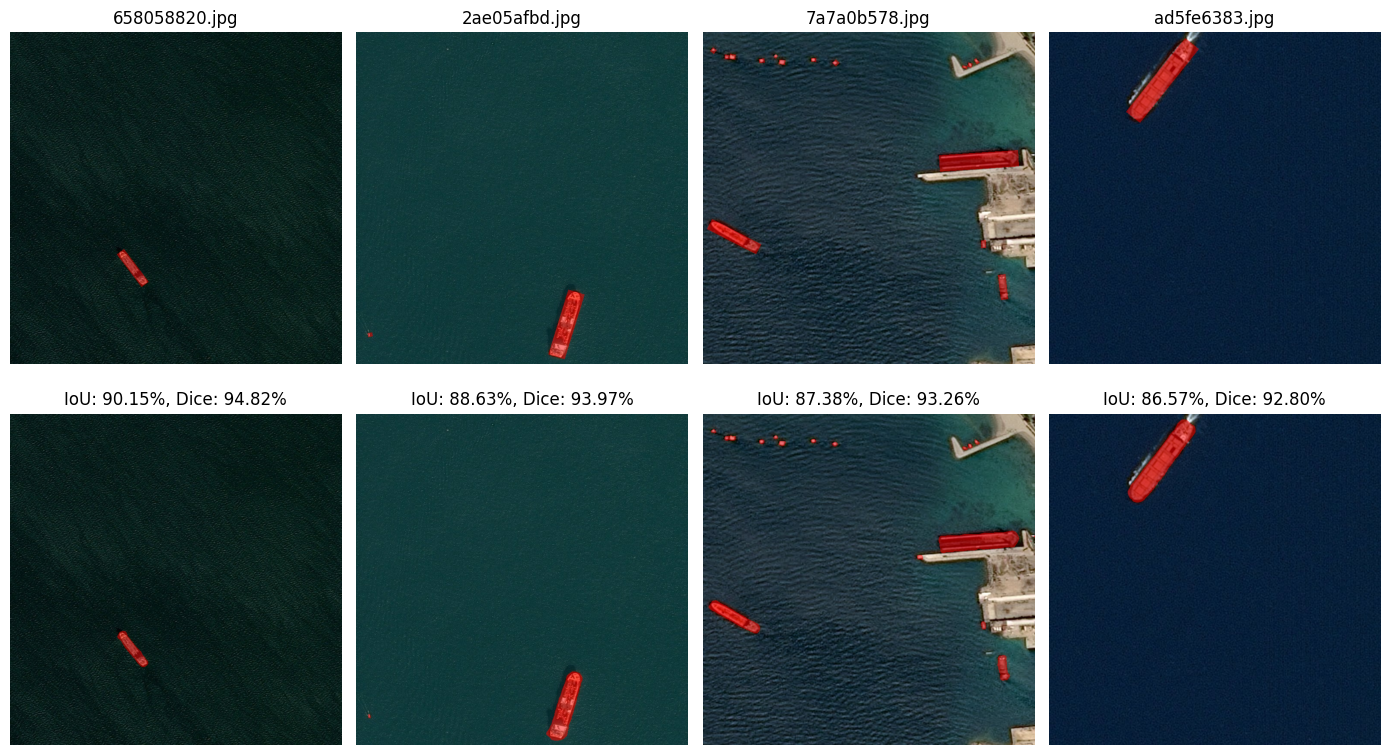

In [10]:
# See some of the best performing images
num_samples = 4
ixs = np.random.choice(best_performing.index.values, size=num_samples, replace=False)
create_plots(ixs)